# A preliminary pipeline to collect features

In [1]:
import jusipy
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# Load datasets
LM        = jusipy.deals.LandMatrix()
A_country = jusipy.country_features.All()
A_latlong = jusipy.latlong_features.All()
GLCF_8km  = A_latlong.datasets[2]         # extract from A_latlong, just to not load this one twice...

Loading GLCF(8km)                                                                                                     reas)                                                                                                      

/Users/thiesgehrmann/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (3,17,25,26,28,34,35,37,39,41,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Load GIS tools
GC = jusipy.GIS.GoogleCode(cache=jusipy.utils.FireDict(sub='googlecode'))
CC = jusipy.GIS.CountryCode()
CLL = jusipy.GIS.CountryLatLong()

## Select the points, and get the relevant data

### Positive points from LandMatrix

In [4]:
positive_points = LM.M[['lat', 'long', 'target_country_iso3', 'negotiation_year']]
positive_points = positive_points.rename(columns={'target_country_iso3' : 'country',
                                                  'negotiation_year' : 'year'})
positive_points['positive'] = 1
positive_points['random']   = 0
positive_points['year'] = positive_points.year.apply(lambda x: 'newest' if pd.isna(x) else x)

### Random points selected from around the earth

In [5]:
random_points = pd.DataFrame(jusipy.GIS.sample.random_latlong(land=True, glcf=GLCF_8km, size=20000),
                             columns=['lat', 'long'])
random_points.to_pickle('data/random_points.pkl')
random_points = pd.read_pickle('data/random_points.pkl')
random_points['country'] = CLL.get(zip(random_points.lat, random_points.long))

random_points['year'] = ['newest'] * len(random_points.lat)
random_points['positive'] = 0
random_points['random']   = 1

random_points = random_points[~pd.isna(random_points.country)]

### Combine the two stacks of data

In [6]:
all_points = pd.concat([positive_points, random_points])
all_points.to_pickle('data/all_points.pkl')
all_points
all_points = pd.read_pickle('data/all_points.pkl')

## Visualize the selected points

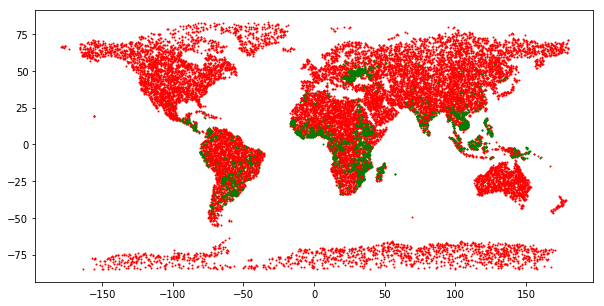

In [7]:
plt.figure(figsize=(10,5))
plt.scatter(all_points.long[all_points.random == 1],
            all_points.lat[all_points.random ==1], c='r', s=1, zorder=1)

plt.scatter(all_points.long[all_points.random == 0],
            all_points.lat[all_points.random ==0], c='g', s=1, zorder=2)


## Collect features for each point

In [26]:
import jusipy
import pandas as pd
all_points = pd.read_pickle('data/all_points.pkl')


country_features = jusipy.country_features.get(all_points, A_country)
latlong_features = jusipy.latlong_features.get(all_points, A_latlong, pixel_window=10)
latlong_features = latlong_features.drop(columns=['coding_error_do_not_use_feature'])
all_features     = pd.concat([country_features, latlong_features], axis=1)

## Impute features, and learn an imputer

In [27]:
imputer = jusipy.impute.SimpleImpute(all_features, strategy='median')
all_imputed_features = imputer.predict(all_features)

WB_LGAF__WB_LGAF2016_1_1_1 categorical
WB_LGAF__WB_LGAF2016_1_1_2 categorical
WB_LGAF__WB_LGAF2016_1_1_3 categorical
WB_LGAF__WB_LGAF2016_1_1_4 categorical
WB_LGAF__WB_LGAF2016_1_2_1 categorical
WB_LGAF__WB_LGAF2016_1_2_2 categorical
WB_LGAF__WB_LGAF2016_1_2_3 categorical
WB_LGAF__WB_LGAF2016_1_2_4 categorical
WB_LGAF__WB_LGAF2016_1_2_5 categorical
WB_LGAF__WB_LGAF2016_1_2_6 categorical
WB_LGAF__WB_LGAF2016_1_2_7 categorical
WB_LGAF__WB_LGAF2016_2_1_1 categorical
WB_LGAF__WB_LGAF2016_2_1_2 categorical
WB_LGAF__WB_LGAF2016_2_1_3 categorical
WB_LGAF__WB_LGAF2016_2_1_4 categorical
WB_LGAF__WB_LGAF2016_2_1_5 categorical
WB_LGAF__WB_LGAF2016_2_1_6 categorical
WB_LGAF__WB_LGAF2016_2_1_7 categorical
WB_LGAF__WB_LGAF2016_2_1_8 categorical
WB_LGAF__WB_LGAF2016_2_2_1 categorical
WB_LGAF__WB_LGAF2016_2_2_2 categorical
WB_LGAF__WB_LGAF2016_2_2_3 categorical
WB_LGAF__WB_LGAF2016_2_2_4 categorical
WB_LGAF__WB_LGAF2016_2_2_5 categorical
WB_LGAF__WB_LGAF2016_2_2_6 categorical
WB_LGAF__WB_LGAF2016_3_1_

WB_SPL__SL_TLF_ACTI_1524_FE_ZS numeric
WB_SPL__SL_TLF_ACTI_1524_MA_NE_ZS numeric
WB_SPL__SL_TLF_ACTI_1524_MA_ZS numeric
WB_SPL__SL_TLF_ACTI_1524_NE_ZS numeric
WB_SPL__SL_TLF_ACTI_1524_ZS numeric
WB_SPL__SL_TLF_ACTI_FE_ZS numeric
WB_SPL__SL_TLF_ACTI_MA_ZS numeric
WB_SPL__SL_TLF_ACTI_ZS numeric
WB_SPL__SL_TLF_ADVN_FE_ZS numeric
WB_SPL__SL_TLF_ADVN_MA_ZS numeric
WB_SPL__SL_TLF_ADVN_ZS numeric
WB_SPL__SL_TLF_BASC_FE_ZS numeric
WB_SPL__SL_TLF_BASC_MA_ZS numeric
WB_SPL__SL_TLF_BASC_ZS numeric
WB_SPL__SL_TLF_CACT_FE_NE_ZS numeric
WB_SPL__SL_TLF_CACT_FE_ZS numeric
WB_SPL__SL_TLF_CACT_FM_NE_ZS numeric
WB_SPL__SL_TLF_CACT_FM_ZS numeric
WB_SPL__SL_TLF_CACT_MA_NE_ZS numeric
WB_SPL__SL_TLF_CACT_MA_ZS numeric
WB_SPL__SL_TLF_CACT_NE_ZS numeric
WB_SPL__SL_TLF_CACT_ZS numeric
WB_SPL__SL_TLF_INTM_FE_ZS numeric
WB_SPL__SL_TLF_INTM_MA_ZS numeric
WB_SPL__SL_TLF_INTM_ZS numeric
WB_SPL__SL_TLF_PART_FE_ZS numeric
WB_SPL__SL_TLF_PART_MA_ZS numeric
WB_SPL__SL_TLF_PART_ZS numeric
WB_SPL__SL_TLF_TOTL_FE_ZS numeri

In [10]:
all_imputed_features

,WB_SE__WB_NY_GDP_MKTP_KD_ZG,WB_SE__WB_NY_GDP_MKTP_PP_KD,LMM_PICL__LMM_PICL_1TOT,LMM_PICL__LMM_PICL_2FR,LMM_PICL__LMM_PICL_3NFR,LMM_LSIC__LMM_LSIC_10CL,LMM_LSIC__LMM_LSIC_10IP,LMM_LSIC__LMM_LSIC_11AVCL,LMM_LSIC__LMM_LSIC_11AVIP,LMM_LSIC__LMM_LSIC_1CL,...,Mixed Forest,Woodland,Wooded Grassland2,Closed Shrubland,Open Shrubland,Grassland2,Cropland,Bare Ground2,Permanent snow and ice,distance_to_mine
index,,,,,,,,,,,,,,,,,,,,,
0,11.991400,7.606163e+11,74.1,8.70,22.7,3.0,4.0,2.4,2.5,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.300886
0,11.991400,7.606163e+11,74.1,8.70,22.7,3.0,4.0,2.4,2.5,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.569603
0,-0.224911,1.832754e+12,74.1,4.40,22.7,3.0,4.0,2.4,3.3,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.300886
0,-0.224911,1.832754e+12,74.1,4.40,22.7,3.0,4.0,2.4,3.3,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.569603
1,4.739570,7.606163e+11,74.1,8.70,22.7,3.0,4.0,2.4,2.5,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.794380
1,4.739570,7.606163e+11,74.1,8.70,22.7,3.0,4.0,2.4,2.5,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.617288
1,6.970600,3.984290e+10,70.0,70.00,0.0,1.0,1.0,1.1,1.1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.794380
1,6.970600,3.984290e+10,70.0,70.00,0.0,1.0,1.0,1.1,1.1,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.617288
2,13.250100,7.606163e+11,74.1,8.70,22.7,3.0,4.0,2.4,2.5,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.163783


## Detect negatives

In [35]:
neg_umap = jusipy.deals.Negative(labels=all_points, features=all_imputed_features, autorun=False)
neg_umap.run(dimred='umap', bandwidth=2)
neg_umap.get_negatives(threshold=.975)

neg_tsne = jusipy.deals.Negative(labels=all_points, features=all_imputed_features, autorun=False)
neg_tsne.run(dimred='tsne')
neg_umap.get_negatives(threshold=.975)


Selecting negatives
Selecting negatives


array([0, 0, 0, ..., 0, 0, 0])

In [38]:
neg_tsne_lab = neg_tsne.negatives.copy()
neg_umap_lab = neg_umap.negatives.copy()
negatives = 1 * ((neg_tsne_lab == 1) & (neg_umap_lab == 1))

all_points['negative'] = negatives

print('# TSNE negatives:', sum(neg_tsne_lab))
print('# UMAP negatives:', sum(neg_umap_lab))
print('# Both negatives:', sum(negatives))

# TSNE negatives: 8245
# UMAP negatives: 9302
# Both negatives: 8245


No handles with labels found to put in legend.


(<Figure size 1440x2160 with 6 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a2ee3fe48>])

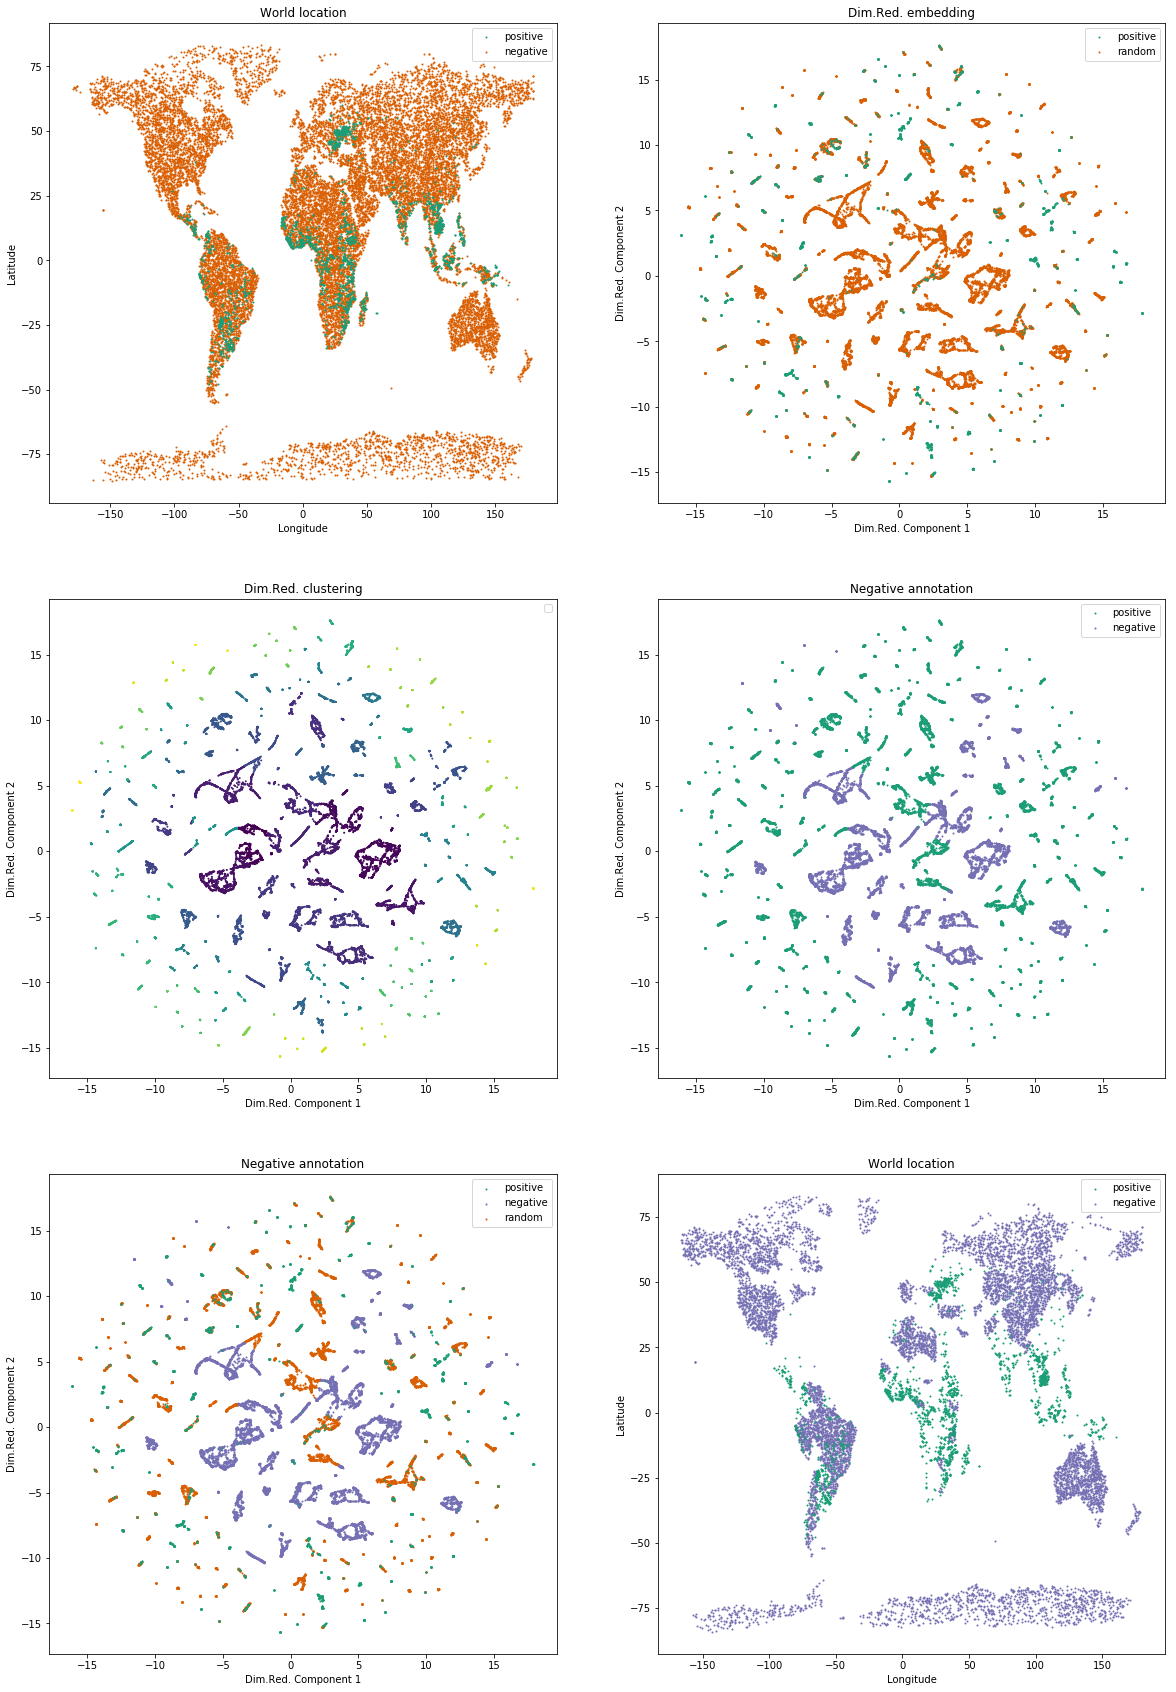

In [30]:
neg_umap.plot()

No handles with labels found to put in legend.


(<Figure size 1440x2160 with 6 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a2efa88d0>])

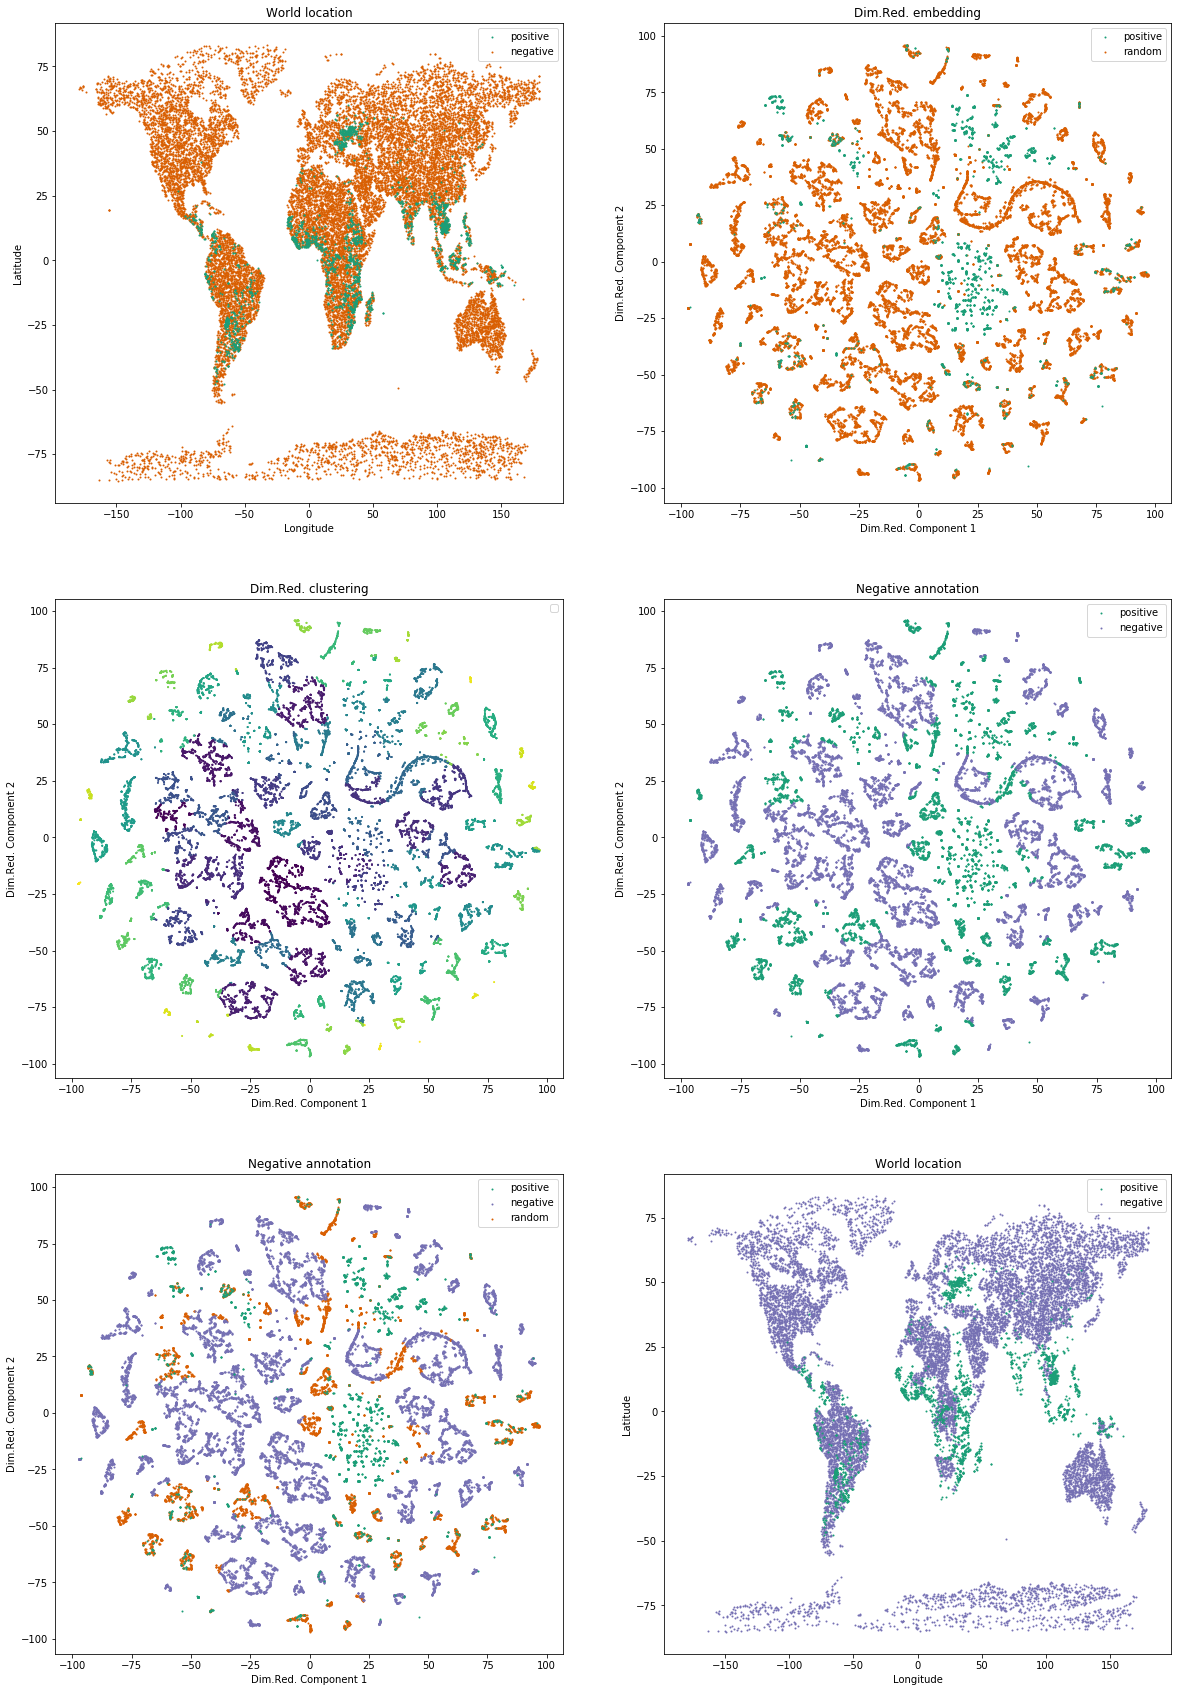

In [29]:
neg_tsne.plot()

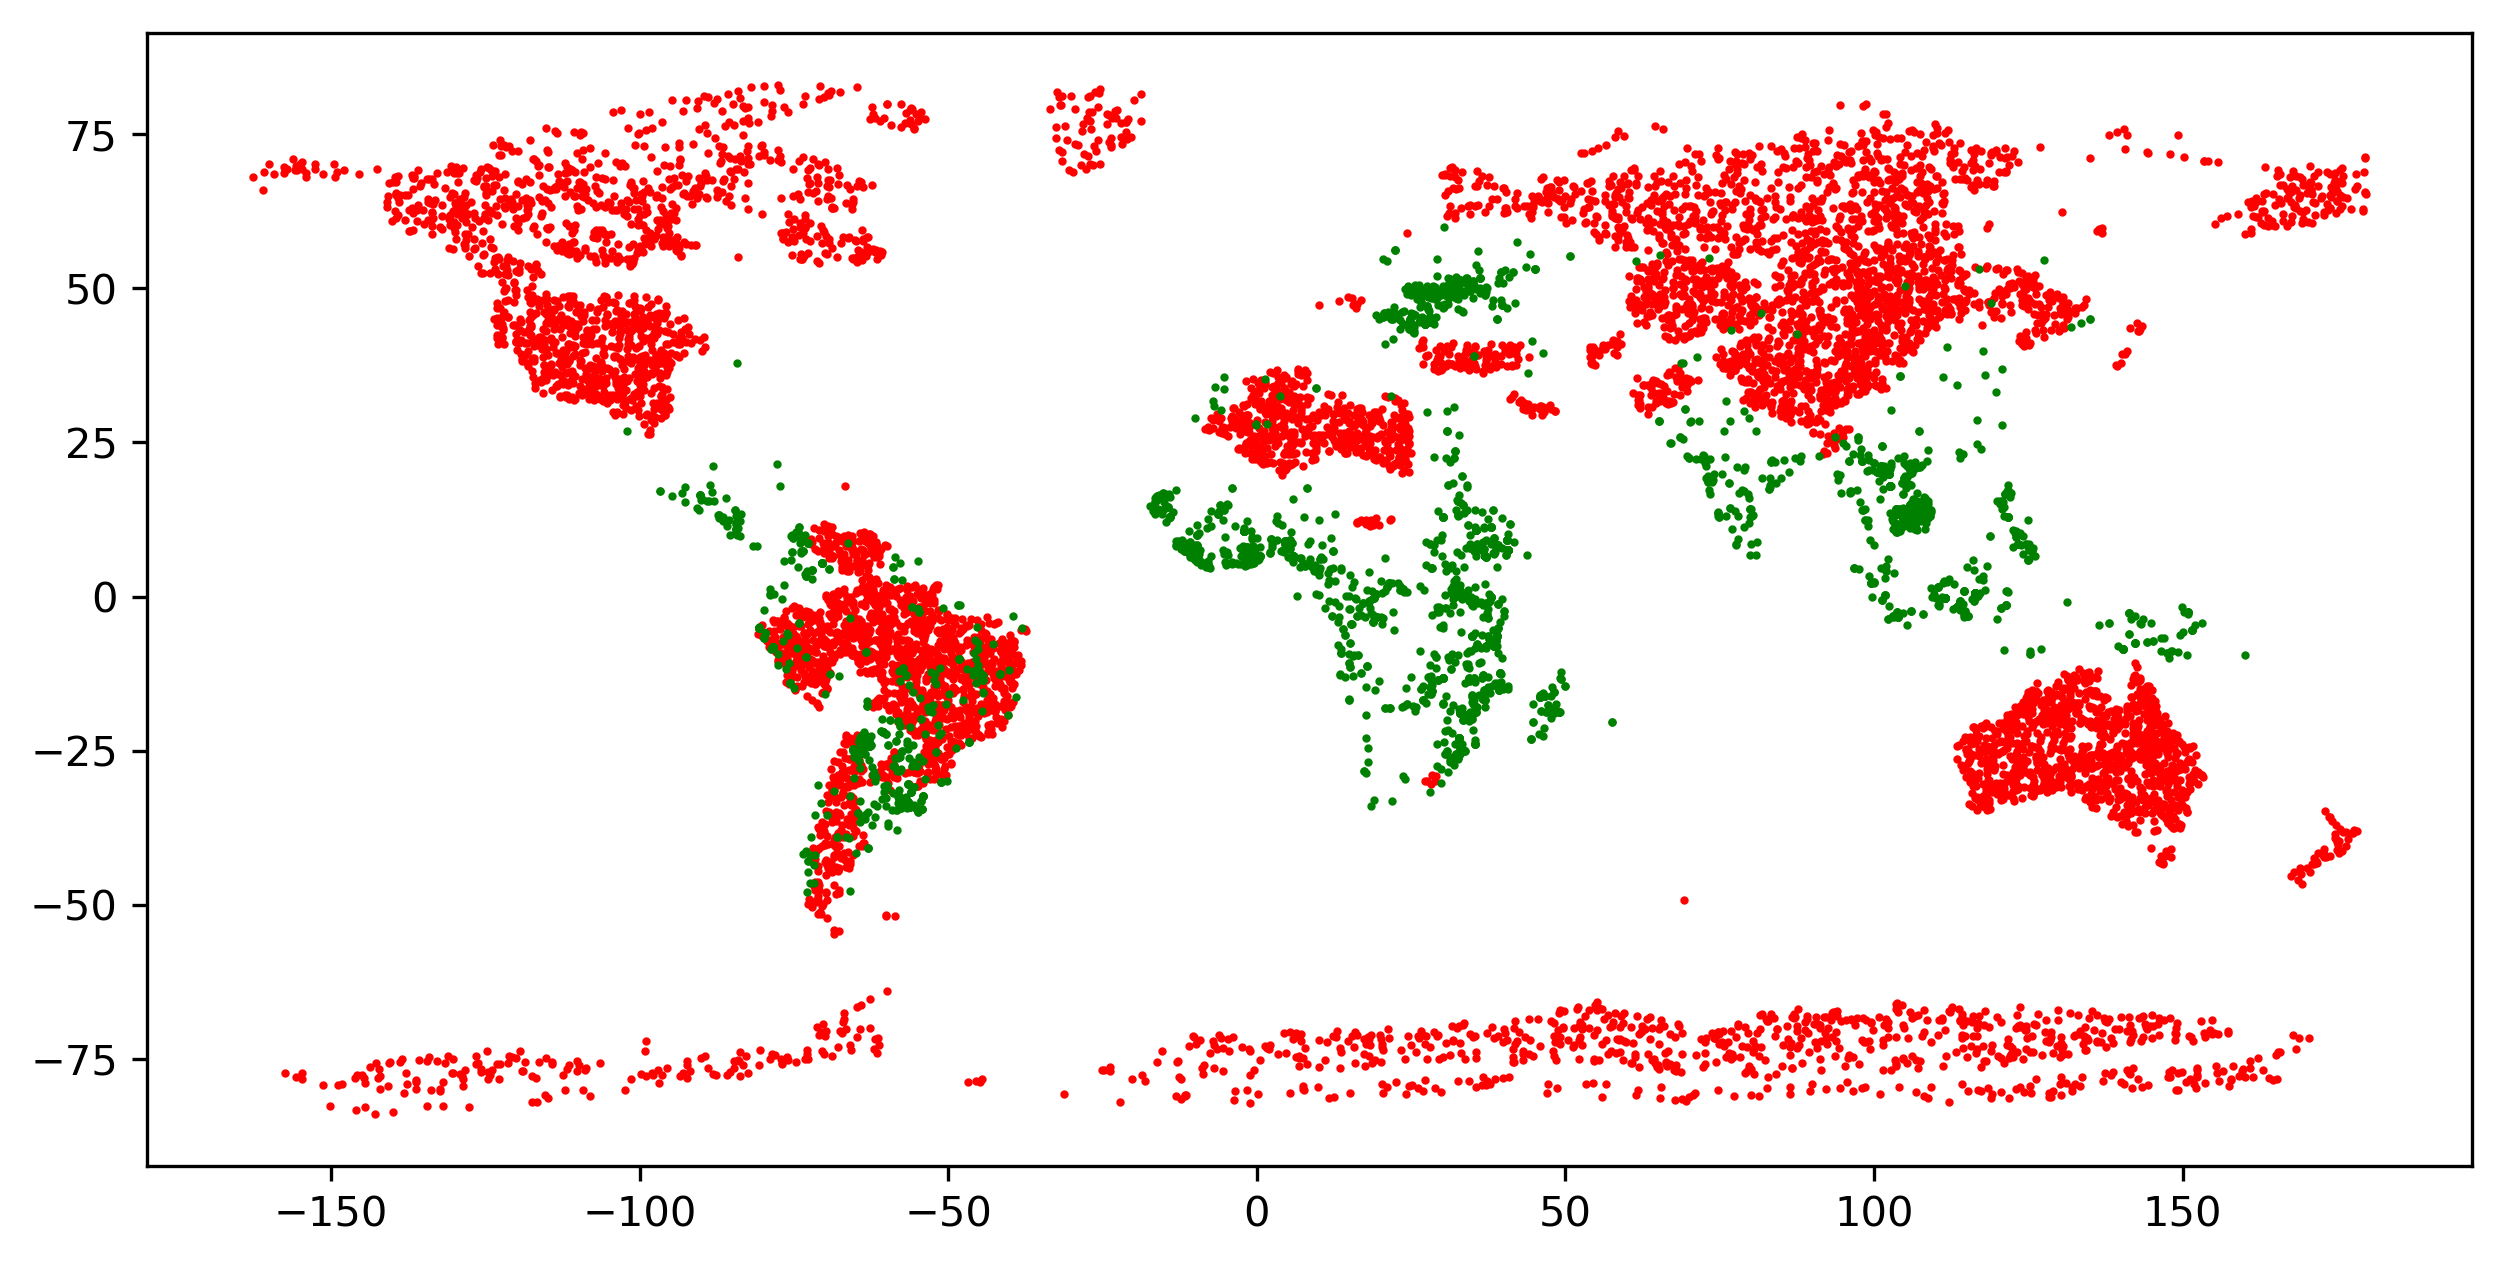

In [42]:
plt.figure(figsize=(10,5),dpi=300)
plt.scatter(all_points.long[all_points.positive == 1],
            all_points.lat[all_points.positive == 1],
            c='g', label='positive', zorder=2, s=1)


plt.scatter(all_points.long[all_points.negative == 1],
            all_points.lat[all_points.negative == 1],
            c='r', label='positive', zorder=1, s=1)

In [44]:
all_imputed_features.to_pickle('data/all_imputed_features.pkl')
all_points.to_pickle('data/all_points.pkl')

### Make a prediction

In [2]:
import pandas as pd
import jusipy
all_points = pd.read_pickle('data/all_points.pkl')
all_imputed_features = pd.read_pickle('data/all_imputed_features.pkl')

In [5]:
all_rel_points   = all_points[ (all_points.positive == 1) | (all_points.negative == 1) ]
all_rel_features = all_imputed_features[ (all_points.positive == 1) | (all_points.negative == 1) ]

In [ ]:
M = jusipy.models.Models(all_rel_features, all_rel_points.positive)
M.fit()

train accuracy for RF: 0.994410889750293
